# Evaluate models trained on Multisource Maptiles datamodule
Models can be:
- beta_vae
- BiVae

## Load libraries

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [5]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [6]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [7]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [8]:
# Data transforms
from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
from src.data.transforms.functional import unnormalize

# Utils
from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info, get_next_version_path, get_ckpt_path
from collections import OrderedDict

In [9]:
# DataModules
from src.data.datamodules import MNISTDataModule, MNISTMDataModule, MonoMNISTDataModule
from src.data.datamodules import MultiMonoMNISTDataModule
# from src.data.datamodules.maptiles_datamodule import MaptilesDataModule # for BetaVAE use this datamodule
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule #for BiVAE



# plModules
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.models.plmodules.iwae import IWAE
from src.models.plmodules.beta_vae import BetaVAE
from src.models.plmodules.bilatent_vae import BiVAE

# Evaluations
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.utilities.cloud_io import load as pl_load
# from src.evaluator.qualitative import save_content_transfers, save_style_transfers, run_both_transfers

# Evaluation NB to load and evaluate a trained model
Steps:
- Define the architecutre of the model to load
- Load the model at `ckpt_path`
- Run the following evaluations

Evaluations:
1. Evaluation of the generative model
- Quantitative: `best_score`, which is the lowest loss computed as an average loss per datapt in the validation set. The loss is the estimate of the negative maginal log-likelihood of the observed data based on the trained model

- Qualitative: 
  - Reconstruction of datapts from train/val datasets
    - This evaluates how well the generative model (encoder-decoder) preserves the information needed to reconstruct the input data after having learned/trained/optimized jointly with/in the presence of its adversary, the style-classifier/discriminator

2. Evaluation of the discriminator
- How well does it discriminate? 
  - based on a style code: the model should predict the style label of the input datapt well
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - based on a content code: the model should say "I'm not sure, aka. all style labels seem equally probable"
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - Q: what is the range of the `loss_s` or `loss_c` for a good style-classifer?
   

## Define data for evaluation

In [10]:
# # Init Multisource-Monochrome MNIST datamodule
# mono_dir = ROOT/'data/Mono-MNIST'
# colors = ['red', 'green', 'blue']
# seed = 123
# in_shape = (3,32,32)
# batch_size = 128

# # Create a multi-source dataset
# dm = MultiMonoMNISTDataModule(
#     data_root=mono_dir,
#     colors=colors,
#     seed=seed,
#     in_shape=in_shape,
#     batch_size=batch_size,
#     shuffle=True,
# )
# dm.setup('fit')


In [11]:
# Instantiate Multisource Maptiles DataModule
all_cities = ['la', 'charlotte', 'vegas', 'boston', 'paris', \
              'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
             'berlin', 'montreal', 'rome']

data_root = Path("/data/hayley-old/maptiles_v2/")
cities = all_cities # ['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
styles = ['StamenTonerBackground'] #'OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (1, 128, 128)
batch_size = 32
print('cities: ', cities)
print('styes: ', styles)
dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

cities:  ['la', 'charlotte', 'vegas', 'boston', 'paris', 'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', 'berlin', 'montreal', 'rome']
styes:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
*** Set the datamodule's df_fns attribute -- Save it for quicker DM init for later runs
Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
n_train, n_val:  3941 1688
train channelwise_mean,std:  [0.86191721] [0.33104054]


In [ ]:
### TODO: Mar 1, 2021
NEED TO REVIEW THIS -- I must've been working on adding city name as a label in tensorboard

In [ ]:
# # Instantiate Maptiles data module
# # Note: We use a different target_transform for the evaluation
# # During training, we used a default target_transform which set the label returned in (x,label) = ds[i]
# # is a style index. In this anaylsis with beta-vae on Maptiles, since beta-vae is about a single source dataset,
# # we don't use the style label at all, neither for the training, nor for the testing.
# # Instead, we are insterested in the (lack of) relation between the embedded latent code (z)'s similarities 
# # and (lack of ) relations to the physical proximities of the maptiles.
# # So, here, when we create a dataset (with the same maptiles and orders as in the training), 
# # we retrieve the information about lat-long-zoom from the recorded maptile metadata
# # __getitem__ returns label_dict = {
#         #    "city": city,
#         #    "style": style,
#         #    "zoom": zoom,
#         #    "coord": coord}
# # Then, if target_transform is specified (ie. not None), then it will be applied to the label_dict
# # before returning as the target_label

# all_cities = ['la', 'charlotte', 'vegas', 'boston', 'paris', \
#               'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
#              'berlin', 'montreal', 'rome']
# cities = all_cities #['berlin']#['paris']
# styles = ['StamenTonerBackground']#['OSMDefault', 'CartoVoyagerNoLabels']
# zooms = ['14']
# in_shape = (1, 64, 64)
# batch_size = 32

# city2idx = {c:i for i,c in enumerate(cities)}
# idx2city = {i:c for i,c in enumerate(cities)} 

# target_transform = transforms.Lambda(
#                     lambda label_dict: city2idx[label_dict["city"]] #todo: try with "coord" for more granular distance comparison using lat-lon
#                 )
# dm = MaptilesDataModule(data_root=DATA_ROOT,
#                         cities=cities,
#                         styles=styles,
#                         zooms=zooms,
#                        in_shape=in_shape,
#                        batch_size=batch_size,
#                         target_transform=target_transform,
#                        )
# dm.setup('fit')
# print("DM: ", dm.name)

In [12]:
dset = dm.train_ds
x, *meta = dm.unpack(dset[0])
print('x_shape: ', x.shape)


coord_str, label_s = meta
print('coord_str: ', coord_str)
print('label_s: ', label_s)


x_shape:  torch.Size([1, 128, 128])
coord_str:  13739-6664
label_s:  0


In [13]:
dl = dm.train_dataloader()


## Define model architecture


In [ ]:
# def get_model_class(model_name: str) -> object:
#     model_name = model_name.lower()
#     return {
#         "three_fcs": ThreeFCs,
#         "vae": VanillaVAE,
#         "iwae": IWAE,
#         "bivae": BiVAE,

#     }[model_name]

In [ ]:
# # Instantiate BetaVAE
# # BetaVAE-resnet-conv-1.000'

# from src.models.plmodules.beta_vae import BetaVAE

# # betas = [0.1 * 3**i for i in range(10)]
# # for kld_weight in [1.0]
# latent_dim = 10
# hidden_dims = [32, 64, 128, 256] #,512]
# act_fn = nn.LeakyReLU()
# learning_rate = 3e-4
# kld_weight = 1.0 #betas[0]
# enc_type = 'resnet'
# dec_type = 'conv'
# # dec_type = 'resnet'

# if enc_type == 'resnet':
#     hidden_dims = [32, 32, 64, 128, 256, 512]

# model = BetaVAE(
#     in_shape=in_shape, 
#     latent_dim=latent_dim,
#     hidden_dims=hidden_dims,
#     learning_rate=learning_rate,
#     act_fn=act_fn,
#     kld_weight=kld_weight,
#     enc_type=enc_type,
#     dec_type=dec_type,
# )


In [ ]:
# ## Init BiVAE
# from src.models.plmodules.bilatent_vae import BiVAE

# # betas = [0.1 * 3**i for i in range(10)]
# # for kld_weight in [1.0]
# n_styles = len(styles)
# latent_dim = 10
# hidden_dims = [32, 64, 128, 256] #,512]
# adversary_dims = [100,100,100]
# act_fn = nn.LeakyReLU()
# learning_rate = 3e-4

# is_contrasive = True
# kld_weight = 1.0 #betas[0]
# adv_loss_weight = 1.0

# enc_type = 'resnet'
# # dec_type = 'conv'
# dec_type = 'resnet'

# if enc_type == 'resnet':
#     hidden_dims = [32, 32, 64, 128, 256]

# model = BiVAE(
#     in_shape=in_shape, 
#     n_styles=n_styles,
#     latent_dim=latent_dim,
#     hidden_dims=hidden_dims,
#     adversary_dims=adversary_dims,
#     learning_rate=learning_rate,
#     act_fn=act_fn,
#     is_contrasive=is_contrasive,
#     kld_weight=kld_weight,
#     adv_loss_weight=adv_loss_weight,
#     enc_type=enc_type,
#     dec_type=dec_type,
# )


## Load model

In [14]:
# log_dir_root = Path("/data/hayley-old/Tenanbaum2000/lightning_logs")
# log_dir_root = Path("/data/hayley-old/Tenanbaum2000/temp_logs")
log_dir_root = Path("/data/hayley-old/Tenanbaum2000/temp-logs")

- Analyzing if we can get a better reconstruction on Maptiles
  - 2021-02-08 (M)

All models were trained with the following same params:
- lr=3e-4
- batch_size=32;


In [ ]:
# # beta=1.0l lr=3e-4; batch_size=32;
# # Model 1: enc,dec = resnet-conv
# log_dir = log_dir_root/ ("BetaVAE-resnet-conv-1.000_"
#                          "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
#                          "StamenTonerBackground_14/version_0"
# )

In [ ]:
# # Model 2: enc,dec = res-conv; beta=10.
# log_dir = log_dir_root/ ("BetaVAE-resnet-conv-10.000_"
#                          "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
#                          "StamenTonerBackground_14/version_0"
# )

In [ ]:
# # Model 1: enc,dec = 
# log_dir = log_dir_root/ ("BetaVAE-resnet-conv-1.000_"
#                          "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
#                          "StamenTonerBackground_14/version_0"
# )

In [ ]:
# # Model 1: enc,dec 
# log_dir = log_dir_root/ ("BetaVAE-resnet-conv-1.000_"
#                          "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
#                          "StamenTonerBackground_14/version_0"
# )

In [17]:
# BiVAE-resnet-resnet: single style maptiles
# -- Trained on Mar 1, 2021
# -- Analysis: started on Mar 4, 2021
log_dir = log_dir_root/("BiVAE-C-resnet-resnet-1.0-1.0_"
                        "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
                        "StamenTonerBackground_14"
                        "/version_0")

In [15]:
# BiVAE-resnet-resnet: single style maptiles
# -- Trained on Mar 1, 2021
# -- Analysis: started on Mar 5, 2021
log_dir = log_dir_root/("BiVAE-C-resnet-resnet-1.0-1.0_"
                        "Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_"
                        "StamenTonerBackground_14"
                        "/version_0")

In [16]:
## Init BiVAE for March 1st trained models
from src.models.plmodules.bilatent_vae import BiVAE

# betas = [0.1 * 3**i for i in range(10)]
# for kld_weight in [1.0]
n_styles = len(styles)
latent_dim = 10
hidden_dims = [32, 64, 128, 256] #,512]
adversary_dims = [100,100,100]
act_fn = nn.LeakyReLU()
learning_rate = 3e-4

is_contrasive = True
kld_weight = 1.0 #betas[0]
adv_loss_weight = 1.0

enc_type = 'resnet'
# dec_type = 'conv'
dec_type = 'resnet'

if enc_type == 'resnet':
    hidden_dims = [32, 32, 64, 128, 256]

model = BiVAE(
    in_shape=in_shape, 
    n_styles=n_styles,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    adversary_dims=adversary_dims,
    learning_rate=learning_rate,
    act_fn=act_fn,
    is_contrasive=is_contrasive,
    kld_weight=kld_weight,
    adv_loss_weight=adv_loss_weight,
    enc_type=enc_type,
    dec_type=dec_type,
)


Get path to checkpoint

In [17]:
ckpt_path = get_ckpt_path(log_dir)
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
print(ckpt.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])


## Load model state from checkpoint

In [20]:
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [28]:
def get_hparams(ckpt: Dict):
    return ckpt['hyper_parameters']
    

## Define a TB writer

In [21]:
# Get the root log_dir correpsonding to the ckpt_path
log_dir = ckpt_path.parent.parent # eg. Folder called `temp-logs/f{model.name+dm.name}/version7`
tb_writer = SummaryWriter(log_dir=log_dir)

In [22]:
tb_writer.log_dir

PosixPath('/data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C-resnet-resnet-1.0-1.0_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_0')

### Recons of inputs from training data

In [ ]:
from src.evaluator.qualitative import show_recon


In [ ]:
best_global_step = ckpt['global_step']
best_global_step

In [ ]:
show_recon(
    model=model, 
    dm=dm, 
    tb_writer=tb_writer, 
    global_step=best_global_step, 
    verbose=True
)

# TODO:
- Test src.evaluator.qualitative.evaluate_transfers
  - when constant_code is 'c' (ie. content transfers)
  - when 's' is contant (ie. style transfers)
  
- The evaulation script on the top 3 trained BiVAE from yesterday
- Run more training?
- OSMNX - compare embedding

---


In [23]:
def get_data_samples(dm: pl.LightningDataModule, 
                     inds: Optional[List]=None,
                     n_reps: int = 10) -> Dict[Union[str,int], torch.Tensor]:
    """Get `n_reps` number of maptiles from random locations, random style(s)"""
    ds = dm.train_dataloader().dataset
    data = {}
    if inds is None:
        inds = np.random.choice(len(ds), n_reps)
    for ind in inds:
        x, y, d = dm.unpack(ds[ind]) #(img, coord_str, style_idx) for MultiSourceMaptiles
        data[(d)] = (x,y)
#         data[str(i)] = x
        
    return data

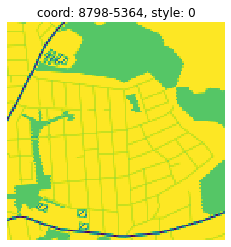

In [24]:
data_reps = get_data_samples(dm, n_reps=10)
# Show content-representative images
for d, (timg, y) in data_reps.items():
    show_timg(timg, title=f"coord: {y}, style: {d}")#, cmap='gray' if in_shape[0]==1 else None)
    plt.show()

In [ ]:
#TODO
# def get_style_reps(dl: DataLoader, n_reps = 10) -> Dict[Union[str,int], torch.Tensor]:
#     """Get `n_reps` number of maptiles from random locations, random style(s)"""
#     ds = dl.dataset
# #     n_styles = 
#     reps = {}
#     inds = np.random.choice(len(ds), n_reps)
#     for i in inds:
#         x, label_s = ds[i] #(img, style_id) for Maptiles in maptiles.py
#         reps[str(i)] = x
#     return reps

## Helper: Get country name from a coord_str
- coord_str: format is {{lat_deg}}-{{lng_deg}}

In [31]:
import math 
from geopy.geocoders import Nominatim

def getGeoFromTile(x, y, zoom):
    lon_deg = x / (2.0 ** zoom) * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y / (2.0 ** zoom))))
    lat_deg = lat_rad * (180.0 / math.pi)
    return lat_deg, lon_deg

def getCountryFromTile(x,y,z, 
                       language='en',
                       reverse_zoom=3) -> str:
    """Given x,y,z tile coords, return Country name.
    
    Args:
    -----
    x,y,z: tile x,y,z
    language: to be used to express the output of OSM's Nominatim service
    zoom: to be passed to Norminatim.reverse -- level of returned address's detail
        - Eg: 3 for country-level, 10 for city, 16 for major streets
        - See more: https://nominatim.org/release-docs/latest/api/Reverse/
    """
    lat_deg, lng_deg = getGeoFromTile(x,y,z)
    geolocator = Nominatim(user_agent="temp")
    location = geolocator.reverse(f"{lat_deg}, {lng_deg}", language=language, zoom=reverse_zoom)
    if location is None:
        location = geolocator.reverse(f"{lat_deg}, {lng_deg}", language=language, zoom=10)
    addr = location.address.split(" ")
    return addr[-1]

def test_getCountryFromTile():
    print("shanghai: ", 
          getCountryFromTile(13703, 6671, 14,
                            language='en',
                            reverse_zoom=3),
          
         )
    print("paris: ", getCountryFromTile(8301, 5639, 14))
test_getCountryFromTile()

shanghai:  China
paris:  France


In [32]:
def coord2xyz(coord_str:str, 
              delimiter='-',
              z=14) -> Tuple[int]:
    lat_deg, lng_deg = list(map(int, coord_str.split(delimiter)))
    return (lat_deg, lng_deg, z)

def coord2country(coord_str: str,
                 delimiter='-', 
                 z: int = 14) -> str:
    tile_xyz = coord2xyz(coord_str, delimiter, z)
    return getCountryFromTile(*tile_xyz)

# Analysis on the latent space
1. Visualize embeddings
    - collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
    - use tb logger
  
2. Nearest neighbor query


## Visualize embeddings
- collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
- use tb logger


In [ ]:
model.eval()
best_global_step = ckpt["global_step"] + 1
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = len(ds) #4096#2048#1024
dl = DataLoader(ds, 
                batch_size=query_size,
                num_workers=16,
                pin_memory=True)

# define embedding/code types to use as the embedding vector
emb_types = ['c','s'] #'z'
with torch.no_grad():
    batch = next(iter(dl))
    x, label_c, label_s = dm.unpack(batch)
    if not isinstance(label_c, np.ndarray):
        label_c = np.array(label_c)
    if not isinstance(label_s, torch.Tensor):
        label_s = torch.tensor(label_s)
    dict_emb = model.get_embedding(x)
    # todo: update dict_emb with z = [c,s] -- if interested in looking at the emb based on the whole latent z
    # z = model.combine(c,s)
    # dict_emb["z"] = z

#     for name, embedding in zip(["z"], [z]):
    for emb_type in emb_types:
        embedding = dict_emb[emb_type]
        # Compute pairwise distance of the embeddings

        
        # log embedding of z_c to tensorboard 
        tb_writer.add_embedding(embedding,
                             label_img=LinearRescaler()(x), 
#                              metadata=[idx2city[city_id.item()] for city_id in label_s],
                             global_step=best_global_step, #todo
                             tag=emb_type
                            )



## Visualize original images of the close neighbors in the latent space
- Compute pairwise distance using cosine similarity
- For each row (ie. a latent code), get the index of the smallest values. 
- Select the images in the batch x and visualize (can do this all in show_timgs)



In [35]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [ ]:
model.eval()
mode = 'train'

ds = getattr(dm, f"{mode}_ds")
query_size = len(ds) #4096#2048#1024
dl = DataLoader(ds, batch_size=query_size, shuffle=True)

max_n_query = 64 # Max number of queries for Nearest Neighbors
metric = 'cosine' #pairwise distance metric in content space

# tsne params
tsne_dim = 2
tsne_p = 5. #10 #perplexity
# tsne_metric = 'euclidean'
tsne_metric = 'cosine' 
tsne = TSNE(n_components=tsne_dim, metric=tsne_metric, perplexity=tsne_p )
emb_types = ['c']
with torch.no_grad():
    batch = next(iter(dl))
    x, label_c, label_s = dm.unpack(batch)
    if not isinstance(label_c, np.ndarray):
        label_c = np.array(label_c)
    if isinstance(label_s, torch.Tensor):
        label_s = label_s.numpy()
    dict_emb = model.get_embedding(x)
    # todo: update dict_emb with z = [c,s] -- if interested in looking at the emb based on the whole latent z
    # z = model.combine(c,s)
    # dict_emb["z"] = z

#     for name, embedding in zip(["z"], [z]):
    for emb_type in emb_types:
        embedding = dict_emb[emb_type]
        # Compute pairwise distance of the embeddings
        pdists = pairwise_distances(embedding.numpy(), metric=metric)
        plt.imshow(pdists, cmap='gray')
        plt.title(f"Pairwise dists of {emb_type}'s")
        plt.axis('off')
        plt.show()
        
        # 1. show the 2dim view on the codes
        embedding_2d = tsne.fit_transform(embedding)
        # -- plot the 2dim embeddings and color-code by style-id
        f, ax = plt.subplots(1, figsize=(20,10))        
        ax.scatter(embedding_2d[:,0], embedding_2d[:,1], c=label_s),
        ax.set_title(f"Code: {emb_type}, colored by style-id")
        ax.axis('equal')
        plt.show()
        
        
        # 2. Nearest neighbor queries
        # smaller values means closer in distance
        n_ngbrs = 10
        n_rows = min(query_size, max_n_query)
        selected_rows = np.random.choice(len(x), size=n_rows)
        for idx in selected_rows:
            args = np.argsort(pdists[idx])[:n_ngbrs]; #print(args)
            country_names = list(map(coord2country, label_c[args]))
            show_timgs(LinearRescaler()(x[args]), 
                       cmap='gray', 
                       factor=2, 
                       nrows=1, 
                       titles=country_names, #cities_of_nn
#                        title=f'Nearest Maptile, based on {emb_type}',
#                        title=f'Nearest of digit {label_s[idx].item()}: {emb_type}'
                      )
            plt.show()
        
        # 3. Add the embedding of this code to Tensorboard Projector
        # Create a list of (country, style_idx) for all data 
        meta = []
        for coord_str, style_idx in zip(label_c, label_s):
            country = coord2country(coord_str)
            meta.append((country, style_idx))

        tb_writer.add_embedding(embedding,
                             label_img=LinearRescaler()(x), 
                             metadata=meta,
                             global_step=best_global_step, #todo
                             tag=emb_type
                            )

Mar 1, 2021 -- pause 7pm
Mar 4, 2021 -- reumed at 2:30pm
TODO
- [ ] Is there evidence that the emb of content code is ignorant of geolocation (ie. city), as well as modality of source?
  - this will show us that our spatial similarity considers not physical location but rather more unintuitive, but meaningful geospatial features
  
- [ ] Save the results to OneNote
- [ ] Test other BiVAE (with different enc,dec types) on this embedding evaluation 
- [ ] Put into OneNote -- for each model setting, add one para summary about the analysis

---
- [ ] try tsne perplexity = higher

## Get the min,max range of the latent space (for each dimension of the latent space)


In [1]:
from sklearn.cluster import KMeans
from torch import linalg as LA

In [ ]:
model.eval()
mode = 'train'
metric = 'cosine' #pairwise distance metric in content space
ds = getattr(dm, f"{mode}_ds")
query_size = 1024 #len(ds) #128 #1024
dl = DataLoader(ds, batch_size=query_size, shuffle=True)


# tsne params
tsne_dim = 2
tsne_p = 5. #10 #perplexity
# tsne_metric = 'euclidean'
tsne_metric = 'cosine' 
tsne = TSNE(n_components=tsne_dim, metric=tsne_metric, perplexity=tsne_p )

emb_type = 'c'
with torch.no_grad():
    batch = next(iter(dl))
    x, label_c, label_s = dm.unpack(batch)
    if not isinstance(label_c, np.ndarray):
        label_c = np.array(label_c)
    if isinstance(label_s, torch.Tensor):
        label_s = label_s.numpy()
    dict_q_params = model.encode(x)
    mu_qc, logvar_qc = dict_q_params["mu_qc"], dict_q_params["logvar_qc"]
    
    # mean norm of code
#     z = dict_emb["z"] # (BS, dim_z)
#     norm_z = LA.norm(z, dim=-1)
#     print("Avg. norm of z: ", norm_z.mean())
    
    mu_qc_min = mu_qc.min(dim=0).values
    mu_qc_max = mu_qc.max(dim=0).values
    print("Min mu_qz's range: ", mu_qc_min)
    print("Max mu_qz's range: ", mu_qc_max)
    


## Latent Space Traversal

### Linear traversal in each dimension

For each content-id's representative code:
  - Fix a style code representative
  - Traverse for each dim of the content code
  - Put the results in a grid where each colm is the dimension of the content and each row shows the traversed content code's reconstruction result (in combination with the fixed style code representative)

In [ ]:
from src.evaluator.qualitative import get_traversals#, run_content_traversal, run_style_traversal
from src.utils.misc import now2str

In [ ]:
def run_latent_traversal(
    model: pl.LightningModule,
    code: torch.Tensor,
    traversal_start: Union[float, Iterable[float]],
    traversal_end: Union[float, Iterable[float]],
    n_traversals: int,
    show: bool = True,
    title: str = '',
    to_save: bool = True,
    out_path: Optional[Path]=None,
) -> torch.Tensor:
    """Given a latent code z, traverse each dimension  $j$ independently, 
    from `traversal_start[j]` to `traversal_end[j]` at `n_traversals` steps. 
    
    Parameters
    ----------
        model : pl.LightningModule; Not a BiVAE; Eg. beta_vae
        code : torch.Tensor; shape (dim_code, ); A single latent code, thus 1Dim vector

        traversal_start : Iterable; length == dim_content
            a vector of floats that indicate the starting point of the traversal
            for each dimsion of the content code
        traversal_end : Iterable; length == dim_content
            a vector of floats that indicate the ending point of the traversal
            for each dimsion of the content code
        n_traversals : int
            how many traversal steps per dimension
        show : bool
            True to show the result in a grid where $j$th col is the content dim $j$, 
            and the $i$th row shows the $i$th step in that direction.
        title : str
    
    Returns
    -------
        torch.Tensor; shape (`n_traversals`, dim_content, *dim_input_x)
            a batch of reconstructions from each dimension's traversals.
            Eg: output[n][j] contains a (C,H,W) image reconstructed by a $n$th 
            step at content_code's dim jth direction with the fixed style code.
    """
    is_training = model.training
    model.eval()
    code_dim = code.shape[-1]
    try:
        traversal_start[0]
    except TypeError:
        traversal_start = torch.zeros(code_dim).fill_(traversal_start)
    try:
        traversal_end[0]
    except TypeError:
        traversal_end = torch.zeros(code_dim).fill_(traversal_end)
    with torch.no_grad():
        # Traverse for each dim
        grids = [] #k,v = dim_i, batch of recons while traversing in dim_i direction (n_traversals, *dim_x)
        for dim_i in range(code_dim):
            min_dim_i = traversal_start[dim_i]
            max_dim_i = traversal_end[dim_i]
#             print(min_dim_i, max_dim_i)
            c_traversals = get_traversals(code, dim_i, min_dim_i, max_dim_i, n_traversals) # (n_samples, dim_code)
            
            # Pass to the decoder
            recons = model.decode(c_traversals)

            grid = torchvision.utils.make_grid(LinearRescaler()(recons), nrow=1) # Caveat: nrow is num of colms! # here: linearlize is applied
            grids.append(grid)
        grids = torch.cat(grids, dim=2)

        if show:
            show_timg(grids, title=title)
        if to_save:
            out_path = out_path or Path(f'./z_traversal_{now2str()}.png')
            torchvision.utils.save_image(grids, out_path)
        model.train(is_training)
#         return recons

In [ ]:
# Run latent traversals for each code in the randomly sampled input x's
# TODO: Get style_reps
n_reps = 20
n_traversals = 20
out_dir = log_dir/"latent_traversals"
run_name = now2str()
to_save = True
show = False
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created: ", out_dir)

# Here content_id is maptile index for __getitem__ to Maptiles Dataset
with torch.no_grad():

    data_reps = get_data_samples(dm.train_dataloader(), n_reps=n_reps)
    for data_id, x in data_reps.items():
        dict_emb = model.get_embedding(x[None]) # single datapoint
        z = dict_emb["z"][0].detach() # (dim_z,)
        z_recon = model.decode(z[None])
        x_and_recon = torch.cat([x[None], z_recon])
        if to_save:
            torchvision.utils.save_image(LinearRescaler()(x_and_recon), out_dir/f"z_traversals_tile-{data_id}_{run_name}_original.png")

        # Traverse for each dim
        title = f"Latent Traversal: Tile {data_id}"
        traversal_start = mu_qz_min
        traversal_end = mu_qz_max
        run_latent_traversal(model, z, 
                              traversal_start=traversal_start,
                             traversal_end=traversal_end,
                             n_traversals=n_traversals,
                            show=show, 
                            title=title,
                             to_save=to_save,
                             out_path=out_dir/f"z_traversals_tile-{data_id}_{run_name}.png")

---
TO CONTINUE HERE FOR ANALYSIS

### General traversal on an input data point
Unlike #1 above where we traversed per content-id code, we do a general traversal on the whole content space, where we used the content/style representative codes, we traverse on the learned latent dimension.

input x -> mu_c, logvar_c
        -> mu_s, logvar_s -> 

#### Latent content space -- Conditioned on the input

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']  
        label_s = batch['color']

        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]


    # Content Traversal
    title = f"Content Traversal of {mode} datapt"
    out_dir = log_dir/"content_traversals_of_input"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -3
    traversal_end = 3
    run_content_traversal(model, c, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/f"content_traversals_{now2str()}.png")

#### Latent content space -- Unconditioned on the input; Based on the prior distirbution 

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']  
        label_s = batch['color']

        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]


    # Content Traversal
    # Use c from the prior distribution
    title = f"Content Traversal based on prior"
    out_dir = log_dir/"content_traversals_unconditioned"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -4
    traversal_end = 4
    c_prior = torch.zeros_like(c)
    run_content_traversal(model, c_prior, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/(
                             "content_traversals_unconditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                         )
                         )


## Latent Space Traversal: Style space

### Linear traversal in a single dimension

For each content-id's representative code:
  - Fix a style code representative
  - Traverse for each dim of the content code
  - Put the results in a grid where each colm is the dimension of the content and each row shows the traversed content code's reconstruction result (in combination with the fixed style code representative)

In [ ]:
from src.evaluator.qualitative import get_traversals
from src.utils.misc import now2str

In [ ]:
# Run content traversals for each content code that is a representative of each content class
n_traversals = 20
out_dir = log_dir/"style_traversals_of_reps"
run_name = now2str()

to_save = True
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created: ", out_dir)

for style_id in range(n_styles):
    s = style_reps[style_id]
    for content_id in range(n_contents):
        c = content_reps[content_id]
        
        # Traverse for each dim
        traversal_start = mu_qs_mins[style_id]
        traversal_end = mu_qs_maxs[style_id]
    #     traversal_start = torch.zeros_like(c).fill_(-3.0)#mu_qc_mins[content_id]
    #     traversal_end =  torch.zeros_like(c).fill_(3.0)# mu_qc_maxs[content_id]
        title = f"Style Traversal: content {content_id}, style {style_id}"
        run_style_traversal(model, c, s, 
                              traversal_start=traversal_start,
                             traversal_end=traversal_end,
                             n_traversals=n_traversals,
                            show=True, 
                            title=title,
                             to_save=to_save,
                             out_path=out_dir/f"style_traversals_c-{content_id}_s-{style_id}_{run_name}.png")








In [ ]:
# for content_id in range(n_contents):
#     c = content_reps[content_id]
#     content_dim = c.shape[-1]

#     for style_id in range(n_styles):
#         s = style_reps[style_id]
        
#         # Traverse for each dim
#         n_traversals = 10
#         grids = [] #k,v = dim_i, batch of recons while traversing in dim_i direction (n_traversals, *dim_x)
#         for dim_i in range(content_dim):
#             min_dim_i = mu_qc_mins[content_id][dim_i]
#             max_dim_i = mu_qc_maxs[content_id][dim_i]
#             print(min_dim_i, max_dim_i)

#             c_traversals = get_traversals(c, dim_i, min_dim_i, max_dim_i, n_traversals)
#             dict_z = {
#                 "c": c_traversals, 
#                 "s": s.repeat((n_traversals, 1))
#                      }
#             z = model.combine_content_style(dict_z)
#             recons = model.decode(z)
#         #     show_timgs(recons, nrows=n_traversals, title=f"Traversal: Content_id:{content_id}, dim:{dim_i}")

#             grid = torchvision.utils.make_grid(recons, nrow=1) # Caveat: nrow is num of colms!
#             grids.append(grid)
#         grids = torch.cat(grids, dim=2)

#         show_timg(grids, title=f"Content Traversal: content {content_id}, style {style_id}")







### General traversal on an input data point
Unlike #1 above where we traversed per style-id code, we do a general traversal on the whole style space, where we used the content/style representative codes, we traverse on the learned latent style dimension.

input x -> mu_c, logvar_c
        -> mu_s, logvar_s -> 

#### Latent style space -- Conditioned on the input

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']  
        label_s = batch['color']

        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]


    # Style Traversal
    title = f"Style Traversal conditioned on input"
    out_dir = log_dir/"style_traversals_of_input"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 30
    traversal_start = -3.5
    traversal_end = 3.5
    run_style_traversal(model, c, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/(
                         "style_traversals_conditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                         )
)

#### Latent content space -- Unconditioned on the input; Based on the prior distirbution 

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']  
        label_s = batch['color']

        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]


    # Style Traversal
    # Use c from the prior distribution
    title = f"Style Traversal based on prior"
    out_dir = log_dir/"style_traversals_unconditioned"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -4
    traversal_end = 4
    s_prior = torch.zeros_like(s)
    run_content_traversal(model, c, s_prior, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/(
                             "style_traversals_unconditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                         )
                         )


## Generate new style codes via. style code interpolation
Added: Jan 18, 2021
1. Get the cluster centers from style code embeddings: r,g,b codes
2. new style code = interpolate (r,g,b)
3. Take an image -> get its content code -> z = [c, new_style] -> generator?
  - z = [c, r] -> generator
  - z = [c, g] -> gen
  - z = [c, b] -> gen